In [1]:
# Google Colab에서 노트북을 실행하실 때에는
# https://tutorials.pytorch.kr/beginner/colab 를 참고하세요.
%matplotlib inline


# 컴퓨터 비전(Vision)을 위한 전이학습(Transfer Learning)

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)
  **번역**: [박정환](http://github.com/9bow)

이 튜토리얼에서는 전이학습(Transfer Learning)을 이용하여 이미지 분류를 위한
합성곱 신경망을 어떻게 학습시키는지 배워보겠습니다. 전이학습에 대해서는
[CS231n 노트](http://cs231n.github.io/transfer-learning/)_ 에서 더 많은 내용을
읽어보실 수 있습니다.

위 노트를 인용해보면,

    실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에,
    (무작위 초기화를 통해) 맨 처음부터 합성곱 신경망(Convolutional
    Network) 전체를 학습하는 사람은 매우 적습니다. 대신, 매우 큰 데이터셋(예.
    100가지 분류에 대해 120만개의 이미지가 포함된 ImageNet)에서 합성곱
    신경망(ConvNet)을 미리 학습한 후, 이 합성곱 신경망을 관심있는 작업
    을 위한 초기 설정 또는 고정된 특징 추출기(fixed feature extractor)로 사용합니다.

이러한 전이학습 시나리오의 주요한 2가지는 다음과 같습니다:

-  **합성곱 신경망의 미세조정(finetuning)**: 무작위 초기화 대신, 신경망을
   ImageNet 1000 데이터셋 등으로 미리 학습한 신경망으로 초기화합니다. 학습의 나머지
   과정들은 평상시와 같습니다.
-  **고정된 특징 추출기로써의 합성곱 신경망**: 여기서는 마지막에 완전히 연결
   된 계층을 제외한 모든 신경망의 가중치를 고정합니다. 이 마지막의 완전히 연결된
   계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습합니다.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True  # 시작 시 여러 알고리즘을 벤치마킹하여 가장 최적의 알고리즘을 선택
plt.ion()   # 대화형 모드 근데 난 뭔 말인지 도무지 모르겠음...

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/hymenoptera_data

/content/drive/MyDrive/hymenoptera_data


## 데이터 불러오기

데이터를 불러오기 위해 torchvision과 torch.utils.data 패키지를 사용하겠습니다.

여기서 풀고자 하는 문제는 **개미** 와 **벌** 을 분류하는 모델을 학습하는 것입니다.
개미와 벌 각각의 학습용 이미지는 대략 120장 정도 있고, 75개의 검증용 이미지가
있습니다. 일반적으로 맨 처음부터 학습을 한다면 이는 일반화하기에는 아주 작은
데이터셋입니다. 하지만 우리는 전이학습을 할 것이므로, 일반화를 제법 잘 할 수 있을
것입니다.

이 데이터셋은 ImageNet의 아주 작은 일부입니다.

.. Note ::
   데이터를 [여기](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   에서 다운로드 받아 현재 디렉토리에 압축을 푸십시오.



In [5]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 일부 이미지 시각화하기
데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.



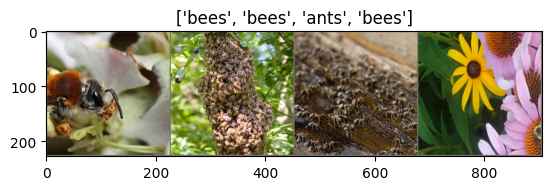

In [6]:
def imshow(inp, title=None):
    """tensor를 입력받아 일반적인 이미지로 보여줍니다."""
    inp = inp.numpy().transpose((1, 2, 0))  # converts the input tensor to a NumPy array
                                            # transposes it to change the shape from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # clips the values to ensure they are between 0 and 1
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 모델 학습하기

이제 모델을 학습하기 위한 일반 함수를 작성해보겠습니다. 여기서는 다음 내용들을
설명합니다:

-  학습률(learning rate) 관리(scheduling)
-  최적의 모델 구하기

아래에서 ``scheduler`` 매개변수는 ``torch.optim.lr_scheduler`` 의 LR 스케쥴러
객체(Object)입니다.



In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # records the current time to measure the duration of the training process
    since = time.time()

    # Create a temporary directory to save training checkpoints
    # automatically clean up when the block exits, ensuring no leftover files
    with TemporaryDirectory() as tempdir:
        # constructs the full path to save the model parameters of the best-performing model
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        # saves the initial state of the model parameters to the temporary file
        # ensures that the best model parameters can be restored later
        torch.save(model.state_dict(), best_model_params_path)
        # initializes a variable to keep track of the highest validation accuracy
        # This will be used to determine if the current model parameters are the best
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 학습 모드로 설정
                else:
                    model.eval()   # 모델을 평가 모드로 설정

                # Initialize running loss to zero for the current phase
                running_loss = 0.0
                #  Initialize the count of correct predictions to zero for the current phase
                running_corrects = 0

                # 데이터를 반복
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 매개변수 경사도를 0으로 설정
                    optimizer.zero_grad()

                    # 순전파
                    # 학습 시에만 연산 기록을 추적
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # 학습 단계인 경우 역전파 + 최적화
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # 통계
                    running_loss += loss.item() * inputs.size(0)
                    # 예측 값과 실제 라벨을 비교하여 일치하는 경우 True, 그렇지 않은 경우 False로 된 텐서를 생성
                    # True 값의 수(맞춘 샘플 수)를 세어서 총 맞춘 샘플 수에 더한다
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # 모델을 깊은 복사(deep copy)함
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        # gets the current time in seconds since the beginning of the training process
        time_elapsed = time.time() - since
        # time_elapsed // 60:.0f : integer division to convert seconds into minutes
        # time_elapsed % 60 : the remainder when dividing the total seconds by 60
        # giving the remaining seconds after accounting for full minutes
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # 가장 나은 모델 가중치를 불러오기
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### 모델 예측값 시각화하기

일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.




In [8]:
def visualize_model(model, num_images=6):
    # stores the current mode of the model so you can restore it later
    was_training = model.training
    model.eval()
    # keeps track of the number of images that have been processed and displayed so far
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 합성곱 신경망 미세조정(finetuning)

미리 학습한 모델을 불러온 후 마지막의 완전히 연결된 계층을 초기화합니다.




In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, ``nn.Linear(num_ftrs, len (class_names))`` 로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 91.8MB/s]


### 학습 및 평가하기

CPU에서는 15-25분 가량, GPU에서는 1분 이내의 시간이 걸립니다.




In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6003 Acc: 0.7090
val Loss: 0.2467 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.6035 Acc: 0.7664
val Loss: 0.5844 Acc: 0.7778

Epoch 2/24
----------
train Loss: 0.6260 Acc: 0.7705
val Loss: 0.4942 Acc: 0.8235

Epoch 3/24
----------
train Loss: 0.5418 Acc: 0.7828
val Loss: 0.2826 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.4864 Acc: 0.8115
val Loss: 0.9687 Acc: 0.6732

Epoch 5/24
----------
train Loss: 0.5725 Acc: 0.7910
val Loss: 0.6344 Acc: 0.7908

Epoch 6/24
----------
train Loss: 0.4796 Acc: 0.8074
val Loss: 0.2584 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3393 Acc: 0.8770
val Loss: 0.2005 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3015 Acc: 0.8607
val Loss: 0.1957 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3534 Acc: 0.8689
val Loss: 0.1953 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2551 Acc: 0.8852
val Loss: 0.2180 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3040 Acc: 0.8648
val Loss: 0.1912 Acc: 0.9281

Ep

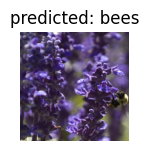

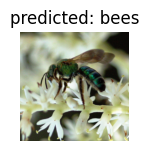

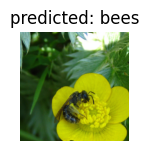

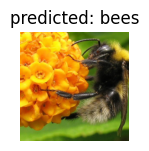

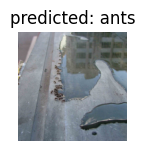

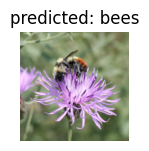

In [11]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망

이제, 마지막 계층을 제외한 신경망의 모든 부분을 고정해야 합니다.
``requires_grad = False`` 로 설정하여 매개변수를 고정하여 ``backward()`` 중에
경사도가 계산되지 않도록 해야합니다.

이에 대한 문서는
[여기](http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_
에서 확인할 수 있습니다.




In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 학습 및 평가하기

CPU에서 실행하는 경우 이전과 비교했을 때 약 절반 가량의 시간만이 소요될 것입니다.
이는 대부분의 신경망에서 경사도를 계산할 필요가 없기 때문입니다. 하지만,
순전파는 계산이 필요합니다.




In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5946 Acc: 0.7213
val Loss: 0.3712 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.5470 Acc: 0.7541
val Loss: 0.4320 Acc: 0.8170

Epoch 2/24
----------
train Loss: 0.5024 Acc: 0.7951
val Loss: 0.1707 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.5428 Acc: 0.7746
val Loss: 0.2134 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.6071 Acc: 0.7172
val Loss: 0.2003 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4875 Acc: 0.8074
val Loss: 0.1911 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.5972 Acc: 0.7623
val Loss: 0.2191 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3637 Acc: 0.8443
val Loss: 0.1997 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3456 Acc: 0.8402
val Loss: 0.2087 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4200 Acc: 0.8115
val Loss: 0.1881 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3833 Acc: 0.8361
val Loss: 0.1815 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3584 Acc: 0.8361
val Loss: 0.1929 Acc: 0.9412

Ep

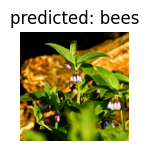

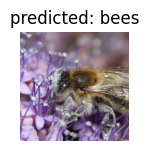

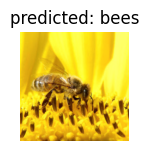

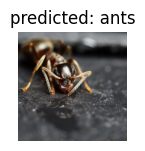

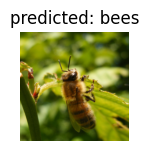

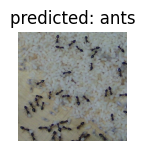

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## 다른 이미지들에 대한 추론

학습된 모델을 사용하여 사용자 지정 이미지에 대해 예측하고,
예측된 클래스 레이블을 이미지와 함께 시각화합니다.




In [15]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

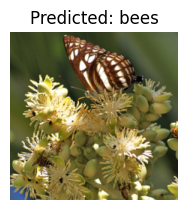

In [18]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## 더 배워볼 내용

전이학습의 응용 사례(application)들을 더 알아보려면,
:doc:`/intermediate/quantized_transfer_learning_tutorial` 을 참조해보세요.



